# 아이솔레이션 포레스트(Isolation Forest)
- 이상값을 식별하는 새로운 머신러닝 기법
- 대규모 데이터셋을 다룰 때 k-최근접 이웃의 좋은 대안이 됨
- 알고리즘의 효율성 덕분에 대규모 샘플과 많은 수의 특징(변수)를 처리할 수 있음
- https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf
---
- 데이터 포인트가 격리될(isolated) 때까지 데이터를 연속적으로 파티셔닝해 이상값을 찾음
- 데이터 포인트를 격리하는데 필요한 파티션 수가 적을수록 높은 이상 점수를 얻는다.
> 참고 : 시스템 자원을 많이 사용하지 않음

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
covidtotals = pd.read_csv('./data/covidtotals.csv')
covidtotals.set_index('iso_code', inplace = True)

### 표준화된 분석 데이터프레임 생성
- 누락 데이터 행 제거
- 표준화

In [5]:
analysisvars = ['location', 'total_cases_pm', 'total_deaths_pm', 'pop_density', 'median_age', 'gdp_per_capita']

standardizer = StandardScaler()
covidtotals.isnull().sum()

lastdate            0
location            0
total_cases         0
total_deaths        0
total_cases_pm      1
total_deaths_pm     1
population          0
pop_density        12
median_age         24
gdp_per_capita     28
hosp_beds          46
dtype: int64

In [8]:
covidanalysis = covidtotals.loc[:, analysisvars].dropna()

In [9]:
covidanalysisstand = standardizer.fit_transform(covidanalysis.iloc[:, 1:])

### 아이솔레이션 포레스트 모델 실행, 이상값 탐지
- 이상값 판별 기준(contamination) : 0.1
- 결과 : 18개국이 이상값으로 식별됨(이상 점수 = -1)

In [10]:
clf = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = .1, max_features = 1.0)
clf.fit(covidanalysisstand)

IsolationForest(contamination=0.1)

In [12]:
covidanalysis['anomaly'] = clf.predict(covidanalysisstand)
covidanalysis['scores'] = clf.decision_function(covidanalysisstand)

In [14]:
covidanalysis.anomaly.value_counts()

 1    156
-1     18
Name: anomaly, dtype: int64

- 정상값과 이상값 데이터 프레임 생성

In [17]:
inlier, outlier = covidanalysis.loc[covidanalysis.anomaly==1], covidanalysis.loc[covidanalysis.anomaly==-1]

outlier[['location', 'total_cases_pm', 'total_deaths_pm', 'median_age','gdp_per_capita', 'scores']].sort_values(['scores']).head(10)

,location,total_cases_pm,total_deaths_pm,median_age,gdp_per_capita,scores
iso_code,,,,,,
SGP,Singapore,5962.727,3.931,42.4,85535.383,-0.253493
QAT,Qatar,19753.146,13.190,31.9,116935.600,-0.231206
BEL,Belgium,5037.354,816.852,41.8,42658.576,-0.148185
BHR,Bahrain,6698.468,11.166,32.4,43290.705,-0.118842
LUX,Luxembourg,6418.776,175.726,39.7,94277.965,-0.100558
ESP,Spain,5120.952,580.197,45.5,34272.360,-0.088571
ITA,Italy,3853.985,552.663,47.9,35220.084,-0.079511
NLD,Netherlands,2710.379,347.595,43.2,48472.545,-0.054379
GBR,United Kingdom,4047.403,566.965,40.8,39753.244,-0.052375


### 정상값과 이상값을 도표로 나타내기(3D 시각화)
- 3차원 그래프가 아이솔레이션 포레스트의 모든 특징을 담지는 못하지만, 이상값(빨간점)은 확실히 1인당 GDP와 중위연령이 높다.(정상값에서는 이 값들이 오른쪽에 있는 것이 보통이므로)
- 결과가 KNN 모델에서와 비슷함(카타르, 싱가포르, 홍콩의 이상점수가 큼)

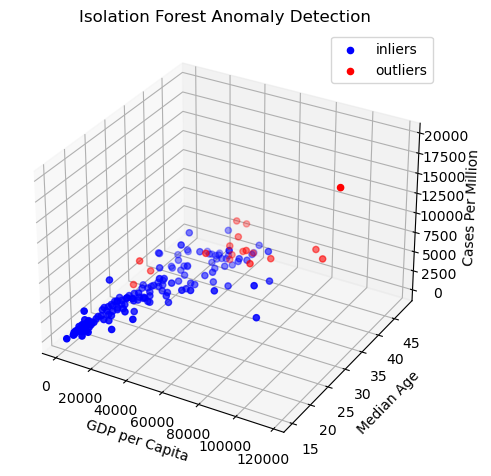

In [22]:
ax = plt.axes(projection = '3d')
ax.set_title('Isolation Forest Anomaly Detection')
ax.set_zlabel('Cases Per Million')
ax.set_xlabel('GDP per Capita')
ax.set_ylabel('Median Age')
ax.scatter3D(inlier.gdp_per_capita, inlier.median_age, inlier.total_cases_pm, label = 'inliers', c = 'blue')
ax.scatter3D(outlier.gdp_per_capita, outlier.median_age, outlier.total_cases_pm, label = 'outliers', c = 'red')
ax.legend()
plt.tight_layout()
plt.show()